In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import datetime as dt
import time
import json
from pyspark.sql import SQLContext
import json
from IPython import display
from IPython.core.display import HTML
import pandas
import time 
import numpy as np
import matplotlib.pyplot as plt 
from pyspark.sql.functions import split, explode, col

sql = SQLContext(sc)

#  KEEP SYDNEY OPEN: 8 OCTOBER 2016
# Event Description:

About 4,000 people have turned out in central Sydney to protest against the New South Wales Government's controversial lockout laws. Aussie rocker Jimmy Barnes threw his support behind the rally, releasing a video message in which he said the lockout laws were not working. The Cold Chisel frontman said he made a career playing in live venues in Sydney, but that attendance at live music venues had dropped 40 per cent since the lockout laws were introduced. The rally heard calls for the 1:30am lockout to be lifted, and for the 10:00pm takeaway cut-off to be reverted to midnight. 

The popular hashtags  for the event were : #keepsydneyopen #KeepSydneyOpen #Nolockouts #nightlivesmatter #keepsydneyopenrally #keepsydneylate

# Get one Week Tweet Before the Event....

In [2]:
lol = sql.read.load(format = "au.com.d2dcrc.carbon.spark.tweets", startTime = "2016-10-01T11:00:00Z", endTime = "2016-10-10T20:10:00Z")
lol.printSchema()


displaytweets = lol.select( "author", "publicationTime", "bodyText", "locations").orderBy("author")
#pd.set_option('display.max_colwidth', 500)
#display.display(displaytweets.toPandas())

root
 |-- key:salt: byte (nullable = true)
 |-- key:timestamp: timestamp (nullable = true)
 |-- key:id: string (nullable = true)
 |-- key:subIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- data: string (nullable = true)
 |-- reference: string (nullable = true)
 |-- format: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- ingestTime: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- civilEvents: string (nullable = true)
 |-- locations: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- nlp: string (nullable = true)
 |-- publicationTime: timestamp (nullable = true)
 |-- politicalParty: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- times: string (nullable = true)
 |-- bodyText: string (nullable = true)
 |-- title: string (nullable = true)
 |-- phraseList: string (nullable = true)



In [3]:
#lol.describe
#realtweet = lol.select('bodyText').dropDuplicates() # 
#realtweet.show()
#sqlContext.registerDataFrameAsTable(realtweet, "table5")
#myretweet = sqlContext.sql("SELECT bodyText FROM table5 WHERE bodyText LIKE '%#%' or '%RT%'").show
#myretweet.show(50)

In [4]:
def get_tweets(df):
    #return rows from dadtframe
    return df.map(lambda row: row.data)

In [5]:
def get_jason(data):
    #returns a pyspark.rdd.PipelinedRDD of jason data
    return data.map(lambda data: json.loads(data))


In [6]:

def get_tweet_body(data):
    #returns a pyspark.rdd.PipelinedRDD of tweet bodies
    tweet_bodies = data.map(lambda tweet_as_json: tweet_as_json.get('body'))
    return tweet_bodies 

In [7]:
#This function obtains geo tag details from json tweets
#input: json data
#output: returns a pyspark.rdd.PipelinedRDD of tweet bodies
def get_tweet_geo(data):
    tweet_geo = data.map(lambda tweet_as_json: tweet_as_json.get('geo',"none"))
    return tweet_geo

In [8]:
def get_tweet_BodyLocation(data):
    bodys_with_location = data.filter(lambda line: 'location' in line).map(lambda line: (line.get('location', "none"),line.get('body',"none")))
    return bodys_with_location

# Specify possible HashTags relating to Event

In [9]:
 #keepsydneyopen #KeepSydneyOpen #Nolockouts #nightlivesmatter #keepsydneyopenrally #keepsydneylate

In [10]:
def get_hashtags(jdata):
    hash_tags = jdata.flatMap(lambda line: line.split(" ")).filter(lambda word: word.startswith('#keepsydneyopen' or '#KeepSydneyOpen' or '#Nolockouts' or '#nightlivesmatter' or '#keepsydneyopenrally' or '#keepsydneylate'))
    return hash_tags 

In [11]:
def hashtag_counter(htags):
    hashtag_counts = htags.map(lambda hashtag: (hashtag, 1)).reduceByKey(lambda a, b: a + b)
    return hashtag_counts

In [12]:
#this fuction returns a given number of common hashtags
#inputs: list of hashtags or hashtag counter dictionary
#output: list of common hashtags 
def common_hashtags(htags,n):
    return Counter(dict(htags)).most_common(n)

In [13]:
#this fuction takes a dictionary and plots key value pairs
def plot_bargraph(d):
    %matplotlib inline
    plt.barh(range(len(d)), d.values(), align="center")
    plt.yticks(range(len(d)), list(d.keys()),rotation='horizontal')
    plt.show()

In [14]:
#df = get_data() #get twitter data for a given number of minutes

df = lol
test =get_tweets(df)
test= get_jason(test)
test=get_tweet_body(test)
hashTags = get_hashtags(test)
hashtag_counts = hashtag_counter(hashTags)

In [15]:
hashtag_count_list = hashtag_counts.take(500)

# Dataset missed most hashtags found in the twitter timeline :
#keepsydneyopen #KeepSydneyOpen #Nolockouts #nightlivesmatter #keepsydneyopenrally #keepsydneylate


In [16]:
#Ten common hashtags 
common_10 = common_hashtags(hashtag_count_list,30) 
print(common_10)

[('#keepsydneyopen', 237), ('#keepsydneyopen…', 6), ('#keepsydneyopen.', 5), ('#keepsydneyopenrally', 5), ('#keepsydneyopen!', 2), ('#keepsydneyopen!!!!!!!', 1)]


In [17]:
type(common_10)

list

In [18]:
#for s in common_10:
#    print(s[0].ljust(8)+(str(s[1])).ljust(30))

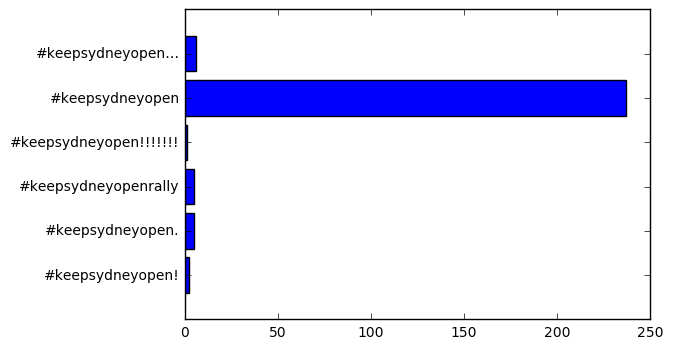

In [19]:
plot_bargraph(dict(common_10))

# Insights on Hashtags Usage
From the above diagram we present preliminary results on how hashtags are used during a protest event.
We selected the top 10 protest related hashtags for the keep sydney open protest.

Our results shows that the phrase "keep

# Futher Analysis:

# Hashtags and Locations
